## 深度学习与艺术 - 神经风格迁移
欢迎来到本周的作业2。在本次作业中，你将学习神经风格迁移。该算法由Gatys等人在2015年创建(https://arxiv.org/abs/1508.06576)。

**在此作业中，你将**：

- 实现神经风格迁移算法
- 使用算法生成新颖的艺术图像

目前你研究的大多数算法都会优化损失函数以获得一组参数值。而在神经样式转换中，你将学习优化损失函数以获得像素值！
- 我：所以这里是优化损失函数得到像素！这就要关注损失函数的计算方式了。之前是用包含权重的公式（反向传播）来表示J，这里应该用包含像素的公式来表示J

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

ModuleNotFoundError: No module named 'nst_utils'

### 1 问题陈述
神经风格迁移（NST）是深度学习中最有趣的技术之一。如下所示，它将“内容”图像（Content）和“风格”图像（Style）合并在一起，以创建“生成”图像（Generated）。生成的图像G将图像C的“内容”与图像S的“风格”组合在一起。

在此示例中，你将巴黎卢浮宫博物馆的图像（内容图像C）与印象派运动的领导者克劳德·莫奈的作品（风格图像S）混合在一起以生成新的图像。
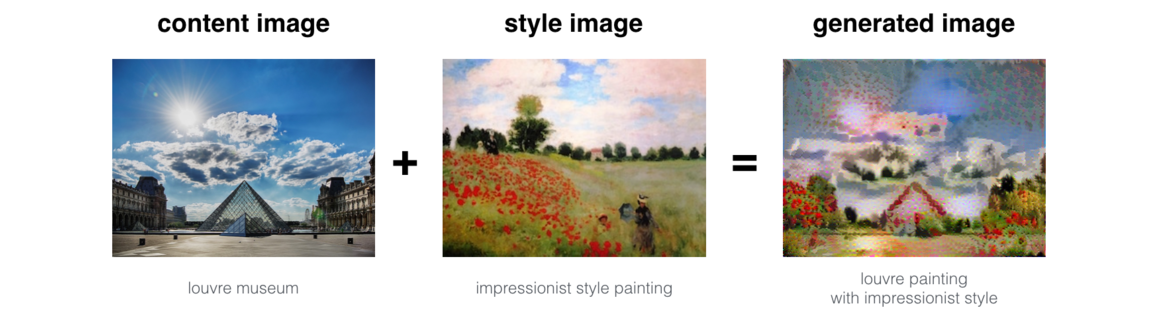

让我们看看如何做到这一点。

### 2 迁移学习
神经风格迁移（NST）使用以前训练过的卷积网络，并以此为基础。将之前经过不同任务训练的网络应用于新任务的想法叫做迁移学习。

遵循原始的NST论文，我们将使用VGG网络。具体来说，我们将使用VGG-19，这是VGG网络的19层版本。该模型已经在非常大的ImageNet数据库上进行了训练，因此已经学会了识别各种低层特征和高层特征。

运行以下代码以从VGG模型加载参数。这可能需要几秒钟。

In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

NameError: name 'load_vgg_model' is not defined

 该模型存储在python字典中，其中每个变量名称都是键，而对应的值是包含该变量值的张量。要通过此网络测试图像，只需要将图像提供给模型。在TensorFlow中，你可以使用 tf.assign函数执行此操作。特别地，你将使用如下的assign函数：
```
model["input"].assign(image)
```

这会将图像分配为模型的输入。此后，如果要访问特定层的激活函数，例如当网络在此图像上运行时说4_2 层，则可以在正确的张量conv4_2上运行TensorFlow会话，如下所示：

```
sess.run(model["conv4_2"])
```

### 3 神经风格迁移
我们将分三步构建NST算法：
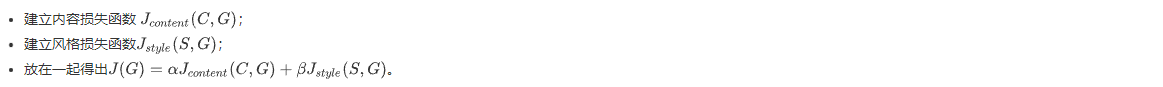

#### 3.1 计算内容损失
在我们的运行示例中，内容图像C是巴黎卢浮宫博物馆的图片。运行下面的代码以查看卢浮宫的图片。

In [3]:
content_image = scipy.misc.imread("images/louvre.jpg")
imshow(content_image)

C:\Users\15831\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


FileNotFoundError: [Errno 2] No such file or directory: 'images/louvre.jpg'

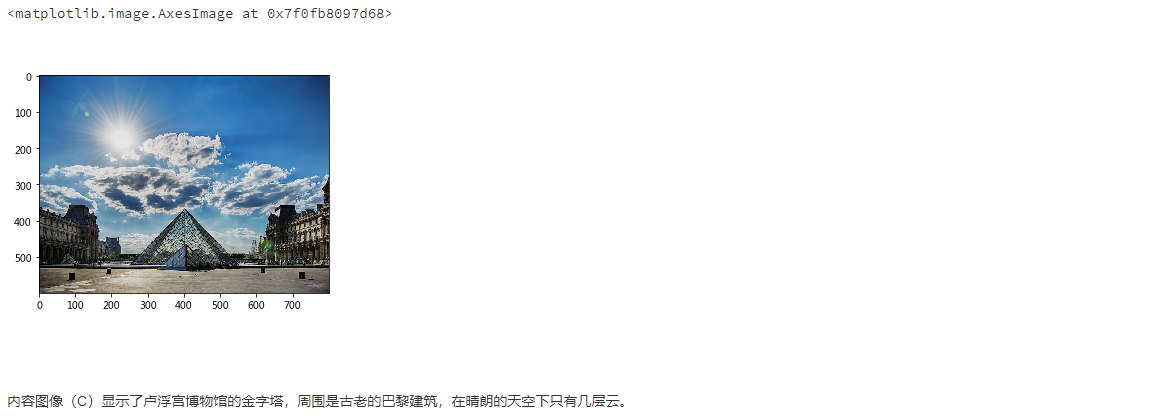

##### 3.1.1 如何确保生成的图像G与图像C的内容匹配？
正如我们在课程中所讲述的，ConvNet的底层倾向于检测诸如边缘和简单纹理之类的低层特征，而深层则倾向于检测诸如纹理之类的更复杂的高层特征。

我们希望生成的图像G具有与输入图像C相似的内容。假设你已选择某些层的激活来表示图像的内容。在实践中，如果在网络中间选择一个层，既不会太浅也不会太深，你将获得视觉上令人满意的结果。（完成本练习后，请随时返回并尝试使用不同的图层，以查看结果变化。）

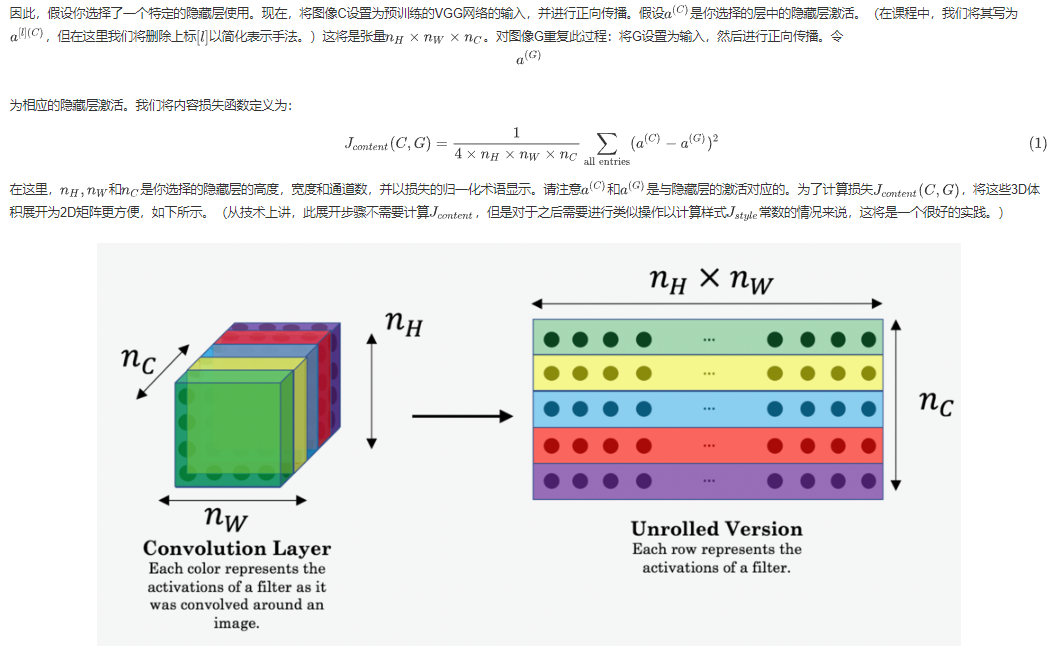

**练习**：使用TensorFlow计算“内容损失”。

**说明**：实现此函数包含3个步骤：
1. 从a_G检索尺寸：
    - 要从张量X检索尺寸，请使用： X.get_shape().as_list()
2. 如上图所示展开a_C和a_G
    - 如果遇到问题，请查看 Hint1 和 Hint2。
3. 计算内容损失：
    - 如果遇到问题，请查看 Hint3, Hint4 和 Hint5。

In [1]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C,shape=(n_H* n_W,n_C))
    a_G_unrolled = tf.reshape(a_G,shape=(n_H* n_W,n_C))

    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4*n_H*n_W*n_C)
    ### END CODE HERE ###
    
    return J_content

In [2]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

NameError: name 'tf' is not defined

**预期输出**:

J_content = 6.7655935

**你应该记住**：
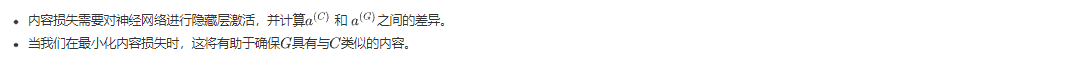

- 我理解：C图输入到VGG网络，从中间某层拿到的输出为aC；不停输入G图，从相同的中间某层拿到输出为aG；减少J的过程中，G图会越来越接近C图，所以训练的结果应该是像素而不是权重（虽然怎么训练的像素在目前还看不到）！

#### 3.2 计算风格损失
我们将使用以下样式图像作为示例运行：

In [3]:
style_image = scipy.misc.imread("images/monet_800600.jpg")
imshow(style_image)

NameError: name 'scipy' is not defined

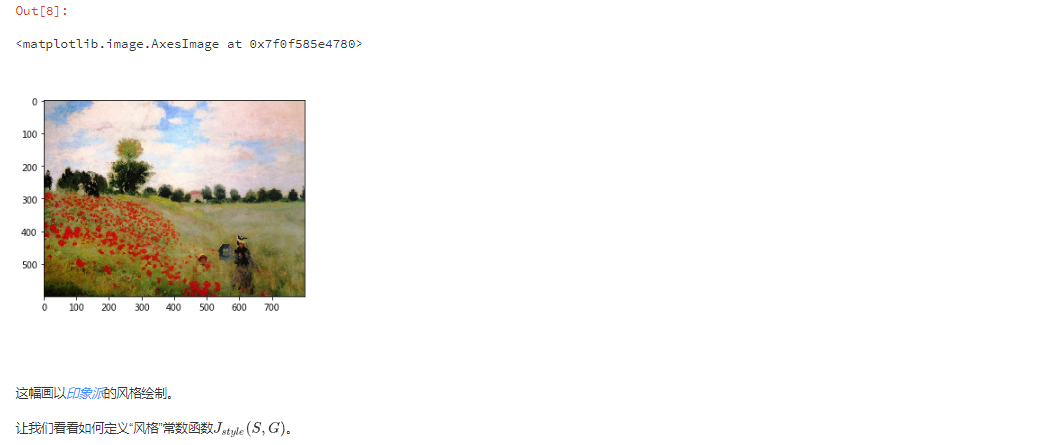

##### 3.2.1 风格矩阵
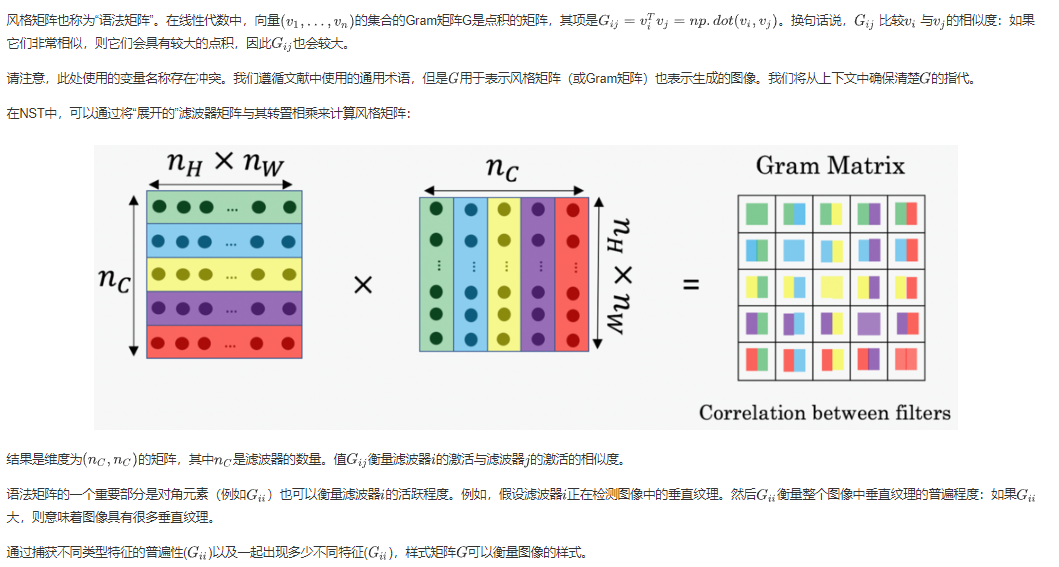

- 问问问：为什么Gii可以衡量滤波器i的活跃程度；明明是滤波器和自己的转置点乘，为啥能衡量图片？
    - 资料：G中Gii表征了各个filter自己的普遍情况，Gij表征了不同filter共同作用的情况，这样G可以衡量一张图片的风格。[参考](https://blog.csdn.net/a1137608040/article/details/119456985)
    - 资料：在feature map中，每个数字都来自于一个特定滤波器在特定位置的卷积，因此每个数字代表一个特征的强度。gram矩阵可以看做feature之间的偏心协方差矩阵（即没有减去均值的协方差矩阵），Gram计算的实际上是两两特征之间的相关性，哪两个特征是同时出现的，哪两个是此消彼长的等等,同时，Gram的对角线元素，还体现了每个特征在图像中出现的量[参考](http://t.csdn.cn/KWl18)
        - 我：图片经过某层卷积后的激活值是在滤波器中的，滤波器中输出的每个激活值数字代表一个特征的强度，这些强度组合在一起就是featuremap；featuremap求协方差矩阵后就知道不同特征之间的关系，和某一特征在图片中是否占主导（对角线）。

**练习**：



In [4]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,tf.transpose(A))
    ### END CODE HERE ###

    
    return GA

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

NameError: name 'tf' is not defined

**预期输出**:

GA = [[ 6.422305 -4.429122 -2.096682]

[-4.429122 19.465837 19.563871]

[-2.096682 19.563871 20.686462]]

##### 3.2.2 风格损失
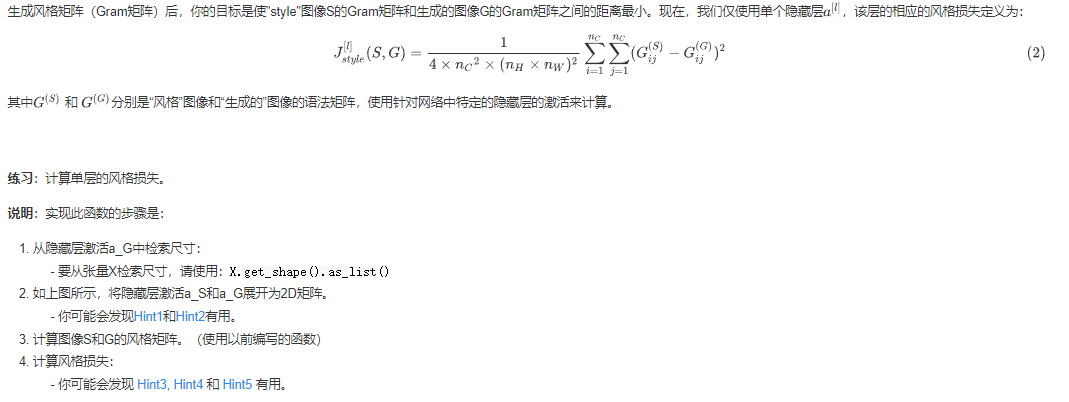

- 问问问：Jstyle的前面的系数是怎么决定的呢？

- 我：两个求和，是说把两个gram矩阵的各个点位都相减平方后加起来。让J变小的同时，就能使S和G图片更接近。

In [7]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
     ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()# 注意这里m是1，所以下面reshape可以直接忽略m

    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(a_S,shape=(n_H* n_W,n_C))
    a_G = tf.reshape(a_G,shape=(n_H* n_W,n_C))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

    # Computing the loss (≈1 line)
    J_style_layer =tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/(4*(n_C*n_C)*(n_W * n_H) * (n_W * n_H))

    ### END CODE HERE ###
    
    return J_style_layer

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

NameError: name 'tf' is not defined

**预期输出**:
    
J_style_layer = 9.190278

##### 3.2.3 风格权重
到目前为止，你仅从一层捕获了风格特征。如果我们从几个不同的层次“合并”风格损失，我们将获得更好的结果。完成此练习后，请随时返回并尝试不同的权重，以查看它如何更改生成的图像G。但现在而言，这是一个合理的默认值：
```
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]
```

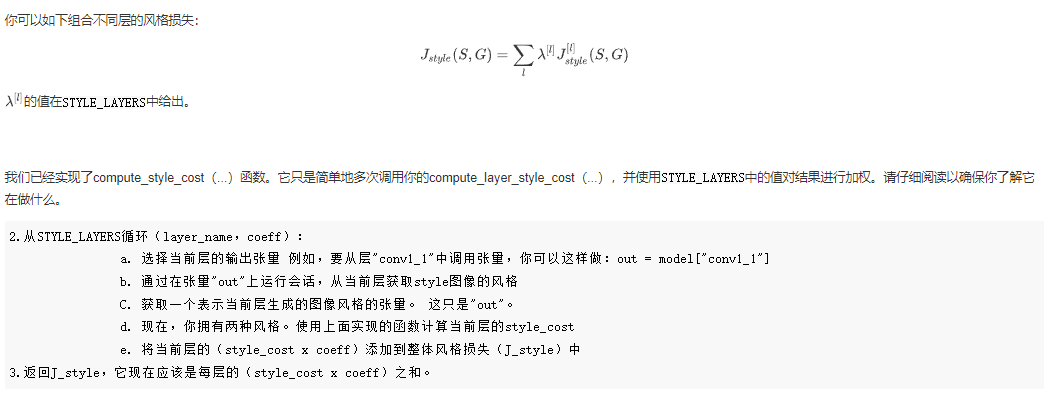

In [9]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

- 我：这里注释说了，G会被投喂给模型，这样就可以在某层的输出拿到aG

**注意**：在上述for循环的内部循环中，a_G是张量，尚未进行求值。当我们在下面的model_nn（）中运行TensorFlow计算图时，它将在每次迭代时进行评估和更新。

<!-- 你如何选择每一层的系数？较深的层捕获更复杂的特征，并且较深的层中的特征在图像中相对于彼此而言定位较少。因此，如果希望生成的图像柔和地跟随风格图像，请尝试为较深的层选择较大的权重，为第一层选择较小的权重。相反，如果希望生成的图像强烈遵循风格图像，请尝试为较低的层选择较小的权重，为第一层选择较大的权重 !-->

**你应该记住**：

- 可以使用隐藏层激活的Gram矩阵表示图像的风格。但是，结合多个不同层的语法矩阵表示，我们可以获得更好的结果。这与内容表示法相反，后者通常仅使用一个隐藏层就足够了。
- 最小化风格损失将导致图像G遵循图像S的风格。

#### 3.3 定义优化的总损失
最后，让我们创建一个损失函数，以最小化风格和内容损失。公式为：



**练习**：实现总损失函数，其中包括内容损失和风格损失。

In [10]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha*J_content+beta*J_style
    ### END CODE HERE ###

    
    return J

In [11]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

NameError: name 'tf' is not defined

**预期输出**:
    
J = 35.34667875478276

**你应该记住**：

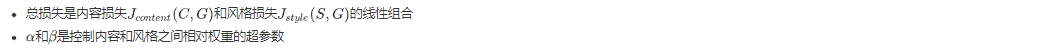

### 4 解决优化问题
最后，让我们将所有内容组合在一起以实现神经风格迁移！

该程序必须执行以下操作：

1. 创建一个交互式会话
2. 加载内容图像
3. 加载风格图像
4. 随机初始化要生成的图像
5. 加载VGG16模型
6. 构建TensorFlow计算图：
     - 通过VGG16模型运行内容图像并计算内容损失
     - 通过VGG16模型运行风格图像并计算风格损失
     - 计算总损失
     - 定义优化器和学习率
7. 初始化TensorFlow图，并运行大量迭代，然后在每个步骤更新生成的图像。

让我们详细介绍各个步骤。

你之前已经实现了总损失J(G) ，我们现在将设置TensorFlow来针对G进行优化。 为此，你的程序必须重置计算图并使用"Interactive Session"。与常规会话不同，交互式会话将启动自身作为默认会话以构建计算图。这使你可以运行变量而无需经常引用会话对象，从而简化了代码。

让我们开始交互式会话。

In [12]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

NameError: name 'tf' is not defined

让我们加载，重塑和标准化我们的“内容”图像（卢浮宫博物馆图片）：

In [13]:
content_image = scipy.misc.imread("images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

NameError: name 'scipy' is not defined

加载，重塑和标准化我们的“风格”图像（克劳德·莫奈的画）：

In [14]:
style_image = scipy.misc.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

NameError: name 'scipy' is not defined

现在，我们将“生成的”图像初始化作为从content_image创建的噪声图像。通过将生成图像的像素初始化为主要是噪声但仍与内容图像稍微相关的像素，这将有助于生成的图像的内容更快速地匹配“内容”图像的内容。（可以在nst_utils.py中查看generate_noise_image（...）的详细信息；为此，请在此Jupyter笔记本的左上角单击"File-->Open..."）

In [15]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

NameError: name 'generate_noise_image' is not defined

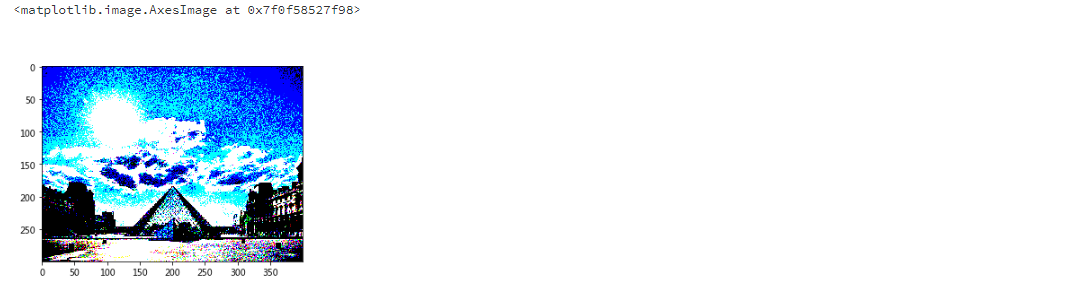

接下来，如第（2）部分所述，让我们加载VGG16模型。



In [17]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

NameError: name 'load_vgg_model' is not defined

为了获得计算内容损失的程序，我们现在将a_C和a_G分配为适当的隐藏层激活。我们将使用conv4_2层来计算内容损失。下面的代码执行以下操作：

1. 将内容图像分配为VGG模型的输入。
2. 将a_C设置为张量，为层"conv4_2"提供隐藏层激活。
3. 设置a_G为张量，为同一层提供隐藏层激活。
4. 使用a_C和a_G计算内容损失。



In [18]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

NameError: name 'sess' is not defined

**注意**：此时，a_G是张量，尚未验证。当我们在下面的model_nn（）中运行Tensorflow计算图时，它将在每次迭代时进行确认和更新。

In [19]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

NameError: name 'sess' is not defined

**练习**：现在你有了J_content和J_style，通过调用total_cost()计算总损失J。 使用alpha = 10 和 beta = 40。

In [20]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style, alpha = 10, beta = 40)
### END CODE HERE ###

NameError: name 'J_content' is not defined

你之前已经学习了如何在TensorFlow中设置Adam优化器。我们在这里使用2.0的学习率。 See reference

In [21]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

NameError: name 'tf' is not defined

**练习**：实现model_nn（）函数，该函数初始化tensorflow计算图的变量，将输入图像（初始生成的图像）作为VGG16模型的输入，并运行train_step进行训练步骤。

In [22]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###

    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    generated_image=sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###

    for i in range(num_iterations):

        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        sess.run(train_step)
        ### END CODE HERE ###

        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

运行以下单元格以生成艺术图像。每运行20次迭代在CPU上大约需要3分钟，但是在大约140次迭代后你开始观察到好的结果。通常使用GPU训练神经风格迁移。



In [23]:
model_nn(sess, generated_image)

NameError: name 'sess' is not defined

**预期输出**:

Iteration 0 :

total cost = 5050363000.0

content cost = 7877.685

style cost = 126257096.0



你完成了！运行此命令后，在笔记本计算机的上方栏中单击"File"，然后单击"Open"。转到"/output"目录以查看所有已保存的图像。打开"generated_image"以查看生成的图像！

你应该看到下面显示的图像：

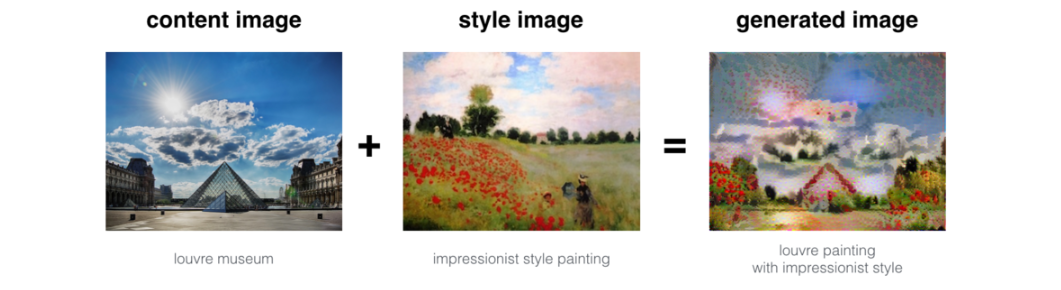

我们不想让你等待太久才能看到初始结果，因此已相应地设置了超参数。为了获得最佳效果，较长的优化算法（可能以较小的学习率）运行效果更好。完成并提交此作业后，我们建议你返回并使用此笔记本进行更多操作，看看是否可以生成外观更好的图像。

### 5 使用你自己的图像进行测试（可选练习）
略

### 6 总结
恭喜你出色地完成这项任务！现在，你可以使用“神经风格迁移”生成艺术图像。这也是你第一次建立模型，在该模型中，优化算法将更新像素值而不是神经网络的参数。深度学习有许多不同类型的模型，这只是其中之一！

你应该记住：

- 神经风格迁移是一种算法，给定内容图像C和风格图像S可以生成艺术图像
- 它使用基于预训练的ConvNet的特征（隐藏层激活）。
- 使用一个隐藏层的激活来计算内容损失函数。
- 使用该层激活的Gram矩阵计算一层的风格损失函数。使用几个隐藏层可以获得整体风格损失函数。
- 优化总损失函数以合成新图像。

这是本课程的最后编程练习。 恭喜，你已经完成了本课程在卷积网络上的所有编程练习！我们希望能在课程5-序列模型中同样看到你的身影。

**参考**：
神经风格迁移算法源于Gatys et al. (2015)。 Harish Narayanan和Github用户"log0"也写了很多精湛的文章，我们从中汲取了灵感。此实现中使用的预训练网络是VGG网络，这是Simonyan和Zisserman（2015）的工作成果。预先训练的权重来自MathConvNet团队的工作。

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576)
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)
- MatConvNet. http://www.vlfeat.org/matconvnet/pretrained/